# Comparing Speeds of pandas and cuDF

In this notebook, we'll explore and analyze how much faster cuDF can be compared to a traditional pandas on data manipulation operations.

The task performed here is a simple one; for various orders of magnitude (called `data_size`, ranging from 10^3 to 10^8), we will:
1. Create a single-column DataFrame with `data_size` rows of numbers `[1, 2, 3, ...]`.
2. Apply a function to all rows; doubling the number in this row.

We will compare the time it takes for both pandas DataFrame and cuDF DataFrames to complete this task.


In [1]:
import cudf
import pandas as pd
import numpy as np
import time

In [2]:
pandas_times = []
cudf_times = []

exps = range(3, 9)

for exp in exps:
    data_length = 10**exp
    print("\ndata length: 1e%d" % exp)

    df = cudf.dataframe.DataFrame()
    df['in1'] = np.arange(data_length, dtype=np.float64)


    def kernel(in1, out):
        for i, x in enumerate(in1):
            out[i] = x * 2.0

    start = time.time()
    df = df.apply_rows(kernel,
                       incols=['in1'],
                       outcols=dict(out=np.float64),
                       kwargs=dict())
    end = time.time()
    print('cuDF time', end-start)
    cudf_times.append(end-start)
    assert(np.isclose(df['in1'].sum()*2.0, df['out'].sum()))


    df = pd.DataFrame()
    df['in1'] = np.arange(data_length, dtype=np.float64)
    start = time.time()
    df['out'] = df.in1.apply(lambda x: x*2)
    end = time.time()
    print('pandas time', end-start)
    pandas_times.append(end-start)
    
    assert(np.isclose(df['in1'].sum()*2.0, df['out'].sum()))



data length: 1e3
cuDF time 0.21834373474121094
pandas time 0.0017337799072265625

data length: 1e4
cuDF time 0.11194753646850586
pandas time 0.002276897430419922

data length: 1e5
cuDF time 0.11534237861633301
pandas time 0.018571853637695312

data length: 1e6
cuDF time 0.11875367164611816
pandas time 0.18403244018554688

data length: 1e7
cuDF time 0.12584137916564941
pandas time 2.0366086959838867

data length: 1e8
cuDF time 0.16527938842773438
pandas time 21.97203516960144


In [3]:
results = cudf.DataFrame()
results["data_size"] = ["1e%d" % exp for exp in exps]
results["pandas_time"] = pandas_times
results["cudf_time"] = cudf_times
results["speedup"] = results["pandas_time"] / results["cudf_time"]
#results = results.set_index('data_size')

#results.transpose()
results

,data_size,pandas_time,cudf_time,speedup
0,1e3,0.001734,0.218344,0.007941
1,1e4,0.002277,0.111948,0.020339
2,1e5,0.018572,0.115342,0.161015
3,1e6,0.184032,0.118754,1.549699
4,1e7,2.036609,0.125841,16.183935
5,1e8,21.972035,0.165279,132.938749


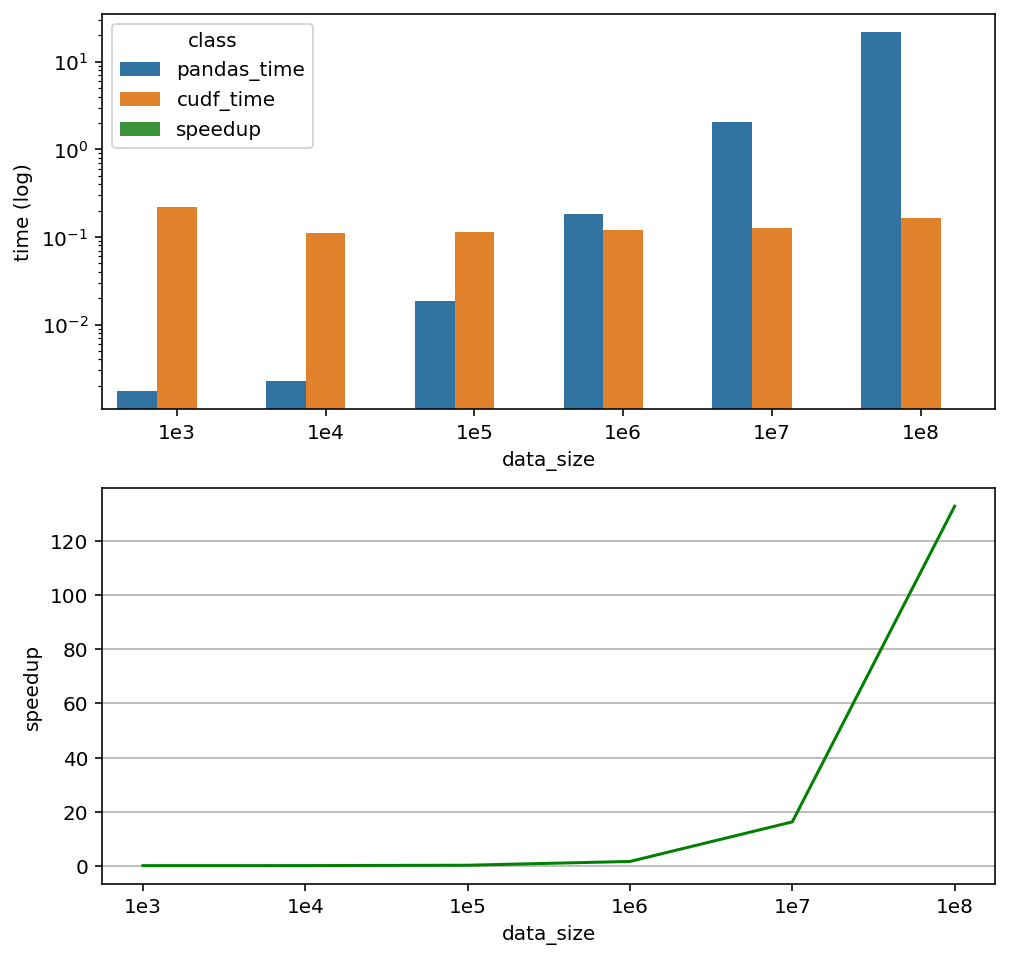

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format ='retina'

df = cudf.melt(results, id_vars=["data_size"], var_name="class", value_name="time")
df_time = df[df['class'] != "speedup"]

# We need to fall back to_pandas for plotting operations
f, ax = plt.subplots(2, 1, figsize=(8,8))
sns.barplot(x="data_size", y="time", hue="class", data=df_time.to_pandas(), ax=ax[0])
ax[0].set_yscale('log')
ax[0].set_ylabel('time (log)')
sns.lineplot(x="data_size", y="speedup", data=results.to_pandas(), ax=ax[1], color='g')
ax[1].yaxis.grid()

# Takeaways

From the graph above, we can clearly see the choice you'll have to make when deciding to switch to GPU for your operations.

For relatively small size of data, the cost of moving this array into GPU memory is not worth the speed of processing that GPU offer, and you lose time. However, as data becomes bigger (10e6 and up), the parallelization capabilities of the GPU becomes really powerful and can speed up the operation up to **120** !